In [248]:
import itertools
import logging
import simpy
import numpy as np

from dataclasses import dataclass
from collections import defaultdict, namedtuple, Counter

import seaborn as sns
sns.set_style("whitegrid")

from matplotlib import pyplot as plt
import pandas as pd

from sim_tools.distributions import Exponential

In [249]:
# Logging config

class SimTimeFilter:
    def __init__(self, env):
        self.env = env

    def filter(self, record):
        record.sim_time = self.env.now
        return True


def setup_logger(env, level = logging.INFO):
    logger = logging.getLogger()
    logger.setLevel(level)

    # Looks like iPython already starts with handlers...
    logger.handlers.clear()

    handler = logging.StreamHandler()
    formatter = logging.Formatter("%(levelname)s - %(sim_time).2f - %(message)s")

    handler.setFormatter(formatter)

    logger.addHandler(handler)
    # Abuse the filter to add new information to the log record (sim_time)
    logger.addFilter(SimTimeFilter(env))

    return logger



In [250]:
SEED = 42
EMERGENCY_MEAN_IAT = 1.5
SURGICAL_DURATION = 2
MEAN_RECOVERY_TIME = 10*24

RUN_LENGTH = 480
NUM_BEDS = 10
NUM_THEATRES = 1
NUM_CC_BEDS = 1

DAILY = 24
WEEKLY = 7 * DAILY

INITIAL_NUMBER_OF_ELECTIVE = 10


class Experiment:
    def __init__(
            self, 
            seed = SEED, 
            initial_number_of_elective = INITIAL_NUMBER_OF_ELECTIVE, 
            emergency_mean_iat = EMERGENCY_MEAN_IAT, 
            surgical_duration = SURGICAL_DURATION, 
            mean_recovery_time = MEAN_RECOVERY_TIME
        ):
        self.patients = []

        self.initial_number_of_elective = initial_number_of_elective

        seeds = np.random.SeedSequence(seed).spawn(3)

        self.emergency_arrival_dist = Exponential(
            emergency_mean_iat, random_seed=seeds[0]
        )
        self.surgical_duration_dist = Exponential(
            surgical_duration, random_seed=seeds[1]
        )
        self.recovery_time_dist = Exponential(
            mean_recovery_time, random_seed=seeds[2]
        )


@dataclass
class Patient:
    id: str
    arrival_time: int = None
    surgical_time: int = None 
    discharge_time: int = None
    surgery_duration: int = None
    recovery_time: int = None

In [251]:
# Theatre

def surgery(env, theatres, beds, cc_beds, patient, experiment, metrics):
    with cc_beds.request() as cc_bed_req, beds.request() as bed_req:
        
        yield cc_bed_req
        yield bed_req

        metrics["bed_event"].append((env.now, 1))

        with theatres.request() as theatre_req:
            yield theatre_req

            surgical_time = env.now
            metrics["surgical_event"].append((surgical_time, 1))

            patient.surgical_time = surgical_time

            yield env.timeout(patient.surgery_duration)
            logging.info(f"{env.now:.2f}: {patient.id} had surgery for: {patient.surgery_duration} hours")
            metrics["surgical_event"].append((env.now, -1))


        # TODO: random select if patient goes to CC (what to do with bed until then?)
        cc_beds.release(cc_bed_req)

        yield env.timeout(patient.recovery_time)

        metrics["bed_event"].append((env.now, -1))

        patient.discharge_time = env.now
        logging.info(f"{patient.id} discharged.")

In [252]:
def scheduler(env, theatres, beds, cc_beds, experiment, waiting_list, metrics):
    # TODO: This parameterisation requires some thought! Take in a schedule object?
    # TODO: Just read from schedule???
    
    while True:
        with waiting_list.get(lambda patient: patient.id[:9] == "Emergency") as waiting_list_req:
            patient = yield waiting_list_req

            logging.info(f"{env.now}: {patient.id} Added to the wait list")
            logging.info(f"{env.now}: Waiting list is now {beds.count}")

            env.process(surgery(env, theatres, beds, cc_beds, patient, experiment, metrics))


In [253]:
# TODO: This could be a template?

def emergency_generator(env, experiment, waiting_list, prefix="Emergency"):
    for patient_count in itertools.count(start=1):
        inter_arrival_time = experiment.emergency_arrival_dist.sample()
        
        yield env.timeout(inter_arrival_time)
        
        p = Patient(f"{prefix}{patient_count}", arrival_time=env.now, surgery_duration=experiment.surgical_duration_dist.sample(), recovery_time=experiment.recovery_time_dist.sample())
        experiment.patients.append(p)

        logger.info(f"{env.now:.2f}: {p.id} referral arrives.")

        waiting_list.put(p)

def elective_generator(env, experiment, waiting_list, prefix="Elective"):
    for patient_count in itertools.count(start=1):
        inter_arrival_time = experiment.emergency_arrival_dist.sample() # TODO: change this for elective
        
        yield env.timeout(inter_arrival_time)
        
        # TODO: change this for elective
        p = Patient(f"{prefix}{patient_count}", arrival_time=env.now, surgery_duration=experiment.surgical_duration_dist.sample(), recovery_time=experiment.recovery_time_dist.sample())
        experiment.patients.append(p)

        logger.info(f"{env.now:.2f}: {p.id} referral arrives.")

        waiting_list.put(p)

def initial_elective_generator(env, experiment, waiting_list, prefix="Elective"):
    for patient_count in range(-experiment.initial_number_of_elective, 0):
        p = Patient(f"{prefix}{patient_count}", arrival_time=env.now, surgery_duration=experiment.surgical_duration_dist.sample(), recovery_time=experiment.recovery_time_dist.sample())
        experiment.patients.append(p)

        logger.info(f"{env.now:.2f}: {p.id} referral arrives.")

        waiting_list.items.append(p)


In [267]:
# TODO: Expand schedule to create nice views? Easier to display in an app

class Schedule:
    def __init__(self, slots):
        self.__schedule = defaultdict(lambda : [])
        self.lcm = None

        self.__process_slots(slots)

        self.__processed_schedule = self.__process_schedule(self.__schedule)

    def __process_slots(self, slots):
        repeat_periods = [slot.repeat_period for slot in slots]
        self.lcm = np.lcm.reduce(repeat_periods)

        for slot in slots:
            repeat_slots = itertools.repeat(slot.start_time, self.lcm//slot.repeat_period)
            for multiplicative, start_time in enumerate(repeat_slots):

                processed_time = multiplicative * slot.repeat_period + start_time

                self.__schedule[processed_time] += [{slot.patient_type:slot.end_time - slot.start_time}]

        self.__schedule = dict(sorted(self.__schedule.items()))

    def __getitem__(self, time):
        while time > max(self.__schedule):
            multiple = max(self.__schedule) // self.lcm + 1
            later_schedule = {k+(self.lcm*multiple): v for k,v in self.__schedule.items()}
            self.__schedule |= later_schedule

            df = self.__process_schedule(later_schedule)
            self.__processed_schedule = pd.concat([self.__processed_schedule, df]).reset_index(drop=True)
            
        return self.__schedule.get(time)
    
    def __process_schedule(self, schedule):
        df = pd.DataFrame(
            [
                [time, list(slot.keys())[0], list(slot.values())[0], []
            ] for time, slots in schedule.items() for slot in slots],
            columns = ["hour", "patient_type", "hours_remaining", "patients"]
        )
        return df

    def schedule_patients(self, patients):
        patient_types = self.__processed_schedule["patient_type"].unique()
        for patient in patients:
            patient_type = patient_types[np.where([patient_type in patient.id for patient_type in patient_types])[0]][0]

            sub_df = self.__processed_schedule.loc[
                (self.__processed_schedule["patient_type"] == patient_type) 
                & (self.__processed_schedule["hours_remaining"] > patient.surgery_duration)
            ]

            # if nothing matches in the schedule currently
            if len(sub_df) == 0:
                max_val = max(self.__schedule)
                self[max_val + 1]

                sub_df = self.__processed_schedule.loc[
                    (self.__processed_schedule["patient_type"] == patient_type) 
                    & (self.__processed_schedule["hours_remaining"] > patient.surgery_duration)
                ]

                if len(sub_df) == 0:
                    raise ValueError(f"Surgery duration for patient {patient.id} is too long for any surgery slot with a duration of {patient.surgery_duration}.")

            row_mask = self.__processed_schedule.index == sub_df.index[0]
            self.__processed_schedule.loc[row_mask, "hours_remaining"] -= patient.surgery_duration
            self.__processed_schedule.loc[row_mask, "patients"].values[0].append(patient.id)


slot = namedtuple("surgery_slot", ["start_time", "end_time", "patient_type", "repeat_period"])

s = Schedule(
    [
        slot(8, 18, "Emergency", DAILY), # 8 - 6 every day 7 days a week
        slot(8, 14, "Elective", WEEKLY), # Once a week between 8 and 2
        slot(32, 42, "Elective", WEEKLY), # Once a week between 8am and 6pm on Tuesday
        slot(34, 36, "Elective", WEEKLY),
        slot(10, 15, "Emergency", DAILY),
        slot(56, 60, "Emergency", WEEKLY),
        slot(24, 48, "Elective", WEEKLY), # Catch all, this will be tidied up when real data is put in
        slot(24, 48, "Emergency", WEEKLY), # Catch all, this will be tidied up when real data is put in
    ]
)

s._Schedule__schedule

{8: [{'Emergency': 10}, {'Elective': 6}],
 10: [{'Emergency': 5}],
 24: [{'Elective': 24}, {'Emergency': 24}],
 32: [{'Emergency': 10}, {'Elective': 10}],
 34: [{'Elective': 2}, {'Emergency': 5}],
 56: [{'Emergency': 10}, {'Emergency': 4}],
 58: [{'Emergency': 5}],
 80: [{'Emergency': 10}],
 82: [{'Emergency': 5}],
 104: [{'Emergency': 10}],
 106: [{'Emergency': 5}],
 128: [{'Emergency': 10}],
 130: [{'Emergency': 5}],
 152: [{'Emergency': 10}],
 154: [{'Emergency': 5}]}

In [268]:
s.schedule_patients(experiment.patients)

C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_15320\1093620846.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.61150191]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.__processed_schedule.loc[row_mask, "hours_remaining"] -= patient.surgery_duration


In [269]:
s._Schedule__processed_schedule

,hour,patient_type,hours_remaining,patients
0,8,Emergency,0.000741,"[Emergency1, Emergency2, Emergency3, Emergency..."
1,8,Elective,0.162249,"[Elective-10, Elective-9, Elective-8, Elective..."
2,10,Emergency,0.010468,"[Emergency9, Emergency10, Emergency13, Emergen..."
3,24,Elective,18.846220,"[Elective-5, Elective-4, Elective-2]"
4,24,Emergency,0.015748,"[Emergency4, Emergency7, Emergency12, Emergenc..."
...,...,...,...,...
155,1282,Emergency,5.000000,[]
156,1304,Emergency,10.000000,[]
157,1306,Emergency,5.000000,[]
158,1328,Emergency,10.000000,[]


In [257]:
# TODO: 
#  Move away from a simpy container for a waiting list?
#  When a new elective comes in, schedule them for the next available slot, keep them on the waiting list though and remove if their surgery happens

In [258]:
# TODO:
# - Paramaterise sim from data
#   - dist for emerg arrivals
#   - dist for surgery duration of emerg patients
#   - dist for recovery time of emerg patients
#   - likelihood of going to CC
#   - dist for CC duration

#   - dist for elec arrivals
#   - dist for surgery duration of elec patients
#   - dist for recovery time of elec patients
#   - likelihood of going to CC
#   - dist for CC duration


# - Link to staffing?
# - Block out hours
# - Add in metrics to show when a resource is blocked
# - prepopulate simulation
# - Need to make sure discharges happen during the day...


In [259]:
def daily_planning(env, waiting_list):
    while True:
        logger.info("New day!!!")
        # TODO: Use the waiting list to schedule the patients...
        yield env.timeout(24)

In [260]:
experiment = Experiment()

metrics = defaultdict(lambda : [])

env = simpy.Environment()

logger = setup_logger(env, logging.INFO)

theatres = simpy.Resource(env, capacity=NUM_THEATRES)
beds = simpy.Resource(env, capacity=NUM_BEDS)
cc_beds = simpy.Resource(env, capacity=NUM_CC_BEDS)
waiting_list = simpy.FilterStore(env)

initial_elective_generator(env, experiment, waiting_list)

env.process(emergency_generator(env, experiment, waiting_list))
env.process(daily_planning(env, waiting_list))
env.process(scheduler(env, theatres, beds, cc_beds, experiment, waiting_list, metrics))

env.run(until=RUN_LENGTH)

INFO - 0.00 - 0.00: Elective-10 referral arrives.
INFO - 0.00 - 0.00: Elective-9 referral arrives.
INFO - 0.00 - 0.00: Elective-8 referral arrives.
INFO - 0.00 - 0.00: Elective-7 referral arrives.
INFO - 0.00 - 0.00: Elective-6 referral arrives.
INFO - 0.00 - 0.00: Elective-5 referral arrives.
INFO - 0.00 - 0.00: Elective-4 referral arrives.
INFO - 0.00 - 0.00: Elective-3 referral arrives.
INFO - 0.00 - 0.00: Elective-2 referral arrives.
INFO - 0.00 - 0.00: Elective-1 referral arrives.
INFO - 0.00 - New day!!!
INFO - 1.45 - 1.45: Emergency1 referral arrives.
INFO - 1.45 - 1.4531664609940464: Emergency1 Added to the wait list
INFO - 1.45 - 1.4531664609940464: Waiting list is now 0
INFO - 4.20 - 4.20: Emergency2 referral arrives.
INFO - 4.20 - 4.195612237234793: Emergency2 Added to the wait list
INFO - 4.20 - 4.195612237234793: Waiting list is now 1
INFO - 4.88 - 4.88: Emergency3 referral arrives.
INFO - 4.88 - 4.881833023975176: Emergency3 Added to the wait list
INFO - 4.88 - 4.88183302

## Analysis

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

Text(0, 0.5, 'Occupied Theatres')

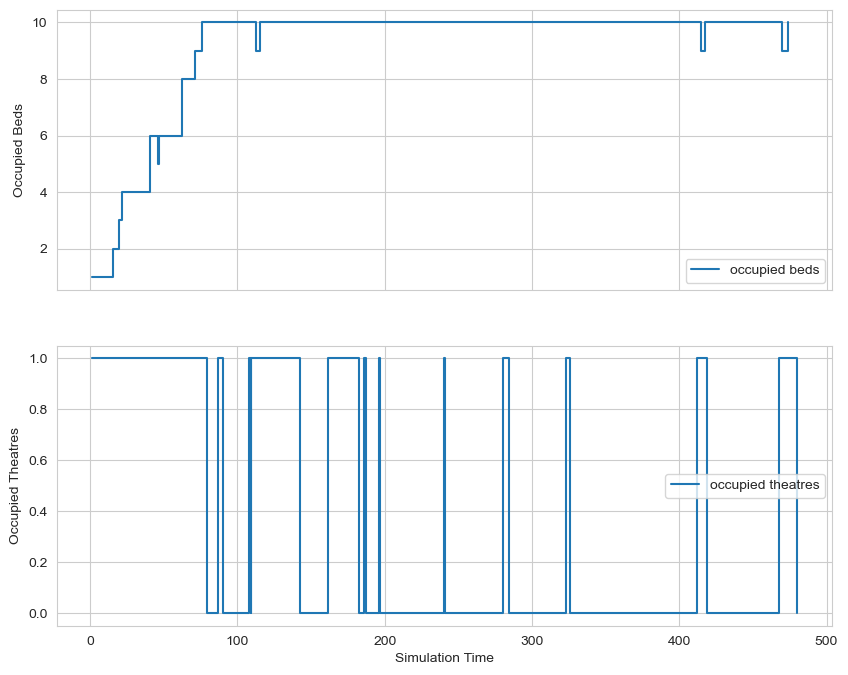

In [ ]:
metrics["bed_event"].sort(key=lambda e: (e[0], e[1]))

bed_events = np.array(metrics["bed_event"])
beds = bed_events[:, 1].cumsum()
df_beds = pd.DataFrame(np.hstack([bed_events, beds.reshape((-1, 1))]), columns=["Simulation time", "Change", "Occupied beds"]).drop_duplicates(subset="Simulation time", keep='last')


metrics["surgical_event"].sort(key=lambda e: (e[0], e[1]))

surgical_event = np.array(metrics["surgical_event"])
surgeries = surgical_event[:, 1].cumsum()
df_surgery = pd.DataFrame(np.hstack([surgical_event, surgeries.reshape((-1, 1))]), columns=["Simulation time", "Change", "Occupied theatres"]).drop_duplicates(subset="Simulation time", keep='last')


fig, ax = plt.subplots(2,1, sharex=True)
fig.set_figheight(8)
fig.set_figwidth(10)

sns.lineplot(df_beds, x="Simulation time", y="Occupied beds", drawstyle='steps-post', label="occupied beds", ax=ax[0])
ax[0].set_xlabel("Simulation Time")
ax[0].set_ylabel("Occupied Beds")

sns.lineplot(df_surgery, x="Simulation time", y="Occupied theatres", drawstyle='steps-post', label="occupied theatres", ax=ax[1])
ax[1].set_xlabel("Simulation Time")
ax[1].set_ylabel("Occupied Theatres")


In [ ]:
surgery_utilisation = (df_surgery["Simulation time"].diff() * df_surgery["Occupied theatres"].shift(1)).sum() / (RUN_LENGTH*NUM_THEATRES) * 100
bed_utilisation = (df_beds["Simulation time"].diff() * df_beds["Occupied beds"].shift(1)).sum() / (RUN_LENGTH*NUM_BEDS) * 100

surgery_utilisation, bed_utilisation

(34.221197879899925, 89.91856315207578)

In [ ]:
experiment.patients

# TODO:
# - Check for metrics and scheduling in papers
# - Record patient history (DNA, hosp cancellations)
# - Separate the patient scheduling from the simulation

# - Write MORE plot code
# - 

[Patient(id='Elective-10', arrival_time=0, surgical_time=None, discharge_time=None, surgery_duration=1.1654942593650781, recovery_time=45.24777856976651),
 Patient(id='Elective-9', arrival_time=0, surgical_time=None, discharge_time=None, surgery_duration=0.527692577894532, recovery_time=84.60355124498531),
 Patient(id='Elective-8', arrival_time=0, surgical_time=None, discharge_time=None, surgery_duration=2.894027592155394, recovery_time=30.999134356091048),
 Patient(id='Elective-7', arrival_time=0, surgical_time=None, discharge_time=None, surgery_duration=0.9062773432745487, recovery_time=337.61518086838316),
 Patient(id='Elective-6', arrival_time=0, surgical_time=None, discharge_time=None, surgery_duration=11.156534900689795, recovery_time=173.57668407591044),
 Patient(id='Elective-5', arrival_time=0, surgical_time=None, discharge_time=None, surgery_duration=4.633613577575327, recovery_time=275.88671600583064),
 Patient(id='Elective-4', arrival_time=0, surgical_time=None, discharge_ti